In [16]:
import pandas as pd
import matplotlib.pyplot as plt

data_df = pd.read_csv("finalalldata.csv")

data_df.shape

(633, 17)

In [4]:
data_df.describe()

,label,sex,age,bmi,smoke,location,rs10007052,rs8192288,rs20541,rs12922394,rs2910164,rs161976,rs473892,rs159497,rs9296092
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,624.000000,628.000000,629.000000,628.000000,629.000000,598.000000,633.000000,595.000000,620.000000
mean,0.696682,1.271722,63.417062,23.190724,0.631912,6.617678,1.391994,0.891881,0.804953,0.859815,1.406741,1.255722,1.299271,1.337422,1.185820
std,0.460055,0.445199,15.369700,3.661055,0.482667,1.523725,0.511025,0.188801,0.199016,0.184891,0.348731,0.387540,0.336951,0.374177,0.492045
min,0.000000,1.000000,21.000000,14.300000,0.000000,4.630000,1.000000,0.351293,0.448632,0.423280,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,55.000000,20.730000,0.000000,5.310000,1.000000,0.592700,0.669800,0.650600,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,66.000000,23.030000,1.000000,6.880000,1.000000,1.000000,0.669800,1.000000,1.416000,1.000000,1.473000,1.445000,1.000000
75%,1.000000,2.000000,75.000000,25.240000,1.000000,7.780000,1.671000,1.000000,1.000000,1.000000,1.416000,1.594000,1.473000,1.445000,1.000000
max,1.000000,2.000000,98.000000,43.560000,1.000000,8.720000,2.792241,1.000000,1.000000,1.000000,2.005056,2.540836,2.169729,2.088025,3.356224


In [5]:
data_df.columns

Index(['uid', 'label', 'sex', 'age', 'bmi', 'smoke', 'location', 'rs10007052',
       'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976',
       'rs473892', 'rs159497', 'rs9296092', 'class'],
      dtype='object')

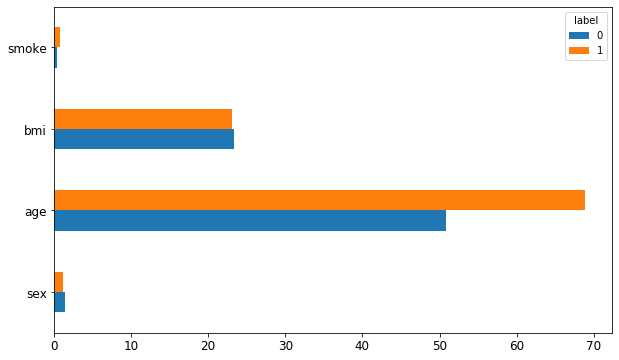

In [34]:
data_df.groupby(['label']).mean()[['sex', 'age', 'bmi', 'smoke']].transpose().plot.barh(figsize=(10,6), fontsize=12);